In [1]:
# -*- coding: utf-8 -*-
"""2025ML_HW3_sample.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1nnX1rSE6SnVEkgKDUEE8G4h4ltCRN0ZA

# ML HW3 Sample Code
TODO:
 - Design your AutoEncoder model
 - Pre-train with unlabelled data
    - Augmentation
 - Fine-tune with labelled data
    - Augmentation
    - Loss function

Report:
 - Clustering
    - Implement Equilibrium K-means algorithm
    - t-SNE : Show the embedding of different classes
 - Anomaly detection
    - Reconstruct unseen classes

## Download data
"""

!gdown 1Bw1ksB6AkTICynIHHkG7NKAdf3sBI1uR
!gdown 1kO12YQxqGFLbY3WiskJyYG7S-hiPae24
!unzip -q 'hw3.zip'

Downloading...
From (original): https://drive.google.com/uc?id=1Bw1ksB6AkTICynIHHkG7NKAdf3sBI1uR
From (redirected): https://drive.google.com/uc?id=1Bw1ksB6AkTICynIHHkG7NKAdf3sBI1uR&confirm=t&uuid=f3fd24a8-dd8d-4d11-a148-4eadd30be651
To: /content/HW3.zip
100% 66.8M/66.8M [00:01<00:00, 53.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1kO12YQxqGFLbY3WiskJyYG7S-hiPae24
From (redirected): https://drive.google.com/uc?id=1kO12YQxqGFLbY3WiskJyYG7S-hiPae24&confirm=t&uuid=3b89c290-c97f-4dd3-b818-b22627ecb898
To: /content/hw3.zip
100% 196M/196M [00:00<00:00, 241MB/s]


In [2]:
"""## Import packages"""

import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision as tv

import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

In [3]:
"""## Datasets and Dataloaders"""

def load_unlabelled(img_dir):
    """
    回傳一個 list of file paths
    """
    all_files = os.listdir(img_dir)
    # 確保檔案是按照 0.jpg, 1.jpg... 的順序
    all_files.sort(key=lambda x: int(x.split('.')[0]))

    paths = [os.path.join(img_dir, f) for f in all_files if f.endswith('.jpg')]
    return paths


def load_labelled(root_dir):
    """
    回傳一個 list of (file_path, label) tuples
    """
    data_with_labels = []
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if not os.path.isdir(label_dir):
            continue

        for img_file in os.listdir(label_dir):
            if img_file.endswith('.jpg'):
                file_path = os.path.join(label_dir, img_file)
                data_with_labels.append((file_path, int(label)))
    return data_with_labels

class ImageDataset(Dataset):
    def __init__(self, imgs, labels=None, tfm=T.ToTensor()):
        super().__init__()
        # 現在 self.imgs 儲存的是 file paths
        # 或者在 labelled 情況下, self.imgs 儲存 (file_path, label)
        self.imgs = imgs
        self.labels = labels
        self.tfm = tfm

    def __getitem__(self, idx):
        if self.labels is None:
            # === Unlabelled data ===
            # self.imgs[idx] 是一個 path
            file_path = self.imgs[idx]
            img = Image.open(file_path).convert('RGB') # 開啟圖片
            return self.tfm(img)
        else:
            # === Labelled data ===
            # self.imgs[idx] 是一個 path
            file_path = self.imgs[idx]
            label = self.labels[idx]
            img = Image.open(file_path).convert('RGB') # 開啟圖片
            return self.tfm(img), label

    def __len__(self):
        return len(self.imgs)

In [4]:
"""## AutoEncoder model
<span style="color:orange">(TODO: Design your model)</span>

<img src="https://julien-vitay.net/lecturenotes-neurocomputing/_images/semisupervised-autoencoder.png" width="500"/>
"""

# TODO: Implement your autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # Input: (B, 3, 64, 64)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),  # <-- 加入 BN
            nn.ReLU(),
            # -> (B, 64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128), # <-- 加入 BN
            nn.ReLU(),
            # -> (B, 128, 16, 16)

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256), # <-- 加入 BN
            nn.ReLU(),
            # -> (B, 256, 8, 8)

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512), # <-- 加入 BN
            nn.ReLU(),
            # -> (B, 512, 4, 4)

            nn.Flatten(start_dim=1),   # -> (B, 512*4*4)

            nn.Linear(512*4*4, 1024),
            nn.BatchNorm1d(1024), # <-- 扁平化後使用 1D BN
            nn.ReLU()             # <-- 建議在 latent vector 之前也加上 ReLU
            # -> (B, 1024)
        )

        # Decoder
        self.decoder = nn.Sequential(
            # Input: (B, 1024)
            nn.Linear(1024, 512*4*4),
            nn.BatchNorm1d(512*4*4), # <-- 加入 1D BN
            nn.ReLU(),
            # -> (B, 512*4*4)

            nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)), # -> (B, 512, 4, 4)

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256), # <-- 加入 BN
            nn.ReLU(),
            # -> (B, 256, 8, 8)

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128), # <-- 加入 BN
            nn.ReLU(),
            # -> (B, 128, 16, 16)

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),  # <-- 加入 BN
            nn.ReLU(),
            # -> (B, 64, 32, 32)

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            # -> (B, 3, 64, 64)

            nn.Sigmoid()  # 輸出層 (0-1), 不加 BN 或 ReLU
        )

        # classifier head
        self.predictor = nn.Sequential(
            # Input: (B, 1024)
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024), # <-- 加入 1D BN
            nn.ReLU(),

            nn.Linear(1024, 10)   # 輸出層 (logits), 不加 BN 或 ReLU
            # -> (B, 10)
        )

    def forward(self, x):
        # encode
        z = self.encoder(x)
        # decode
        x_prime = self.decoder(z)
        # classify
        y = self.predictor(z)
        return x_prime, y, z


In [5]:
"""## Pre-train with unlabelled data
<span style="color:orange">(TODO: Hyperparameter tuning / Augmentation)</span>
"""

def add_noise(x, noise_factor=0.1):
    noise = noise_factor * torch.randn_like(x)
    return x + noise

def pretrain(model, train_loader, valid_loader, config, noise_function=add_noise):
    model = model.to(config.device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_valid_loss = 1e9
    for epoch in range(config.pretrain_epochs):
        model.train()
        train_loss = 0
        for img in tqdm(train_loader):
            img = img.to(config.device)
            optimizer.zero_grad()
            output, _, _ = model(noise_function(img, config.noise_factor))
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        if valid_loader is not None:
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for img in valid_loader:
                    img = img.to(config.device)
                    output, _, _ = model(img)
                    loss = criterion(output, img)
                    valid_loss += loss.item()
                valid_loss /= len(valid_loader)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), config.pretrain_model_path)

            print(f'Epoch {epoch+1}/{config.pretrain_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

In [6]:
"""## Fine-tune with labelled data
<span style="color:orange">(TODO: Loss function / Augmentation)</span>
"""

def loss_fn(x_prime, y, z, x, y_hat):
    # TODO: Define your loss function for fine-tuning
    # You might want to consider the reconstruction loss and/or the classification loss
    # x_prime: 重建的圖片
    # y:       模型的分類輸出 (logits)
    # z:       潛在向量 (此處沒用到)
    # x:       原始圖片
    # y_hat:   真實標籤

    # 1. 重建損失 (MSE)
    recon_loss = nn.MSELoss()(x_prime, x)

    # 2. 分類損失 (Cross Entropy)
    class_loss = nn.CrossEntropyLoss()(y, y_hat)

    # 3. 結合兩種損失
    # alpha 是一個權重，用來平衡兩個任務的重要性
    # 您需要自己調整這個超參數，例如 0.5, 0.1 ...
    alpha = 0.1
    total_loss = class_loss + alpha * recon_loss

    return total_loss

def finetune(model, train_loader, valid_loader, config, noise_function=add_noise):
    model = model.to(config.device)
    criterion = loss_fn
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_valid_loss = 1e9
    for epoch in range(config.finetune_epochs):
        model.train()
        train_loss, train_acc = 0, 0
        for img, label in tqdm(train_loader):
            img, label = img.to(config.device), label.to(config.device)
            optimizer.zero_grad()
            output = model(noise_function(img, config.noise_factor))
            loss = criterion(*output, img, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output[1].argmax(dim=1) == label).float().mean().item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f'Epoch {epoch+1}/{config.finetune_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, label in valid_loader:
                img, label = img.to(config.device), label.to(config.device)
                output = model(img)
                loss = criterion(*output, img, label)
                valid_loss += loss.item()
                valid_acc += (output[1].argmax(dim=1) == label).float().mean().item()
            valid_loss /= len(valid_loader)
            valid_acc /= len(valid_loader)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), config.finetune_model_path)

        print(f'Epoch {epoch+1}/{config.finetune_epochs}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

In [8]:
"""## Testing"""
# TODO: Determine your hyperparameters and augmentation for pretraining
pretrain_train_tfm = T.Compose([
    T.Resize((64, 64)), # 確保圖片大小符合模型輸入
    T.RandomHorizontalFlip(), # 隨機水平翻轉
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 隨機改變亮度、對比度
    T.ToTensor(),
    # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 標準化 (可選，但推薦)
])

# 驗證集通常不做增強，或只做最基本的
pretrain_valid_tfm = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
pretrain_config = Namespace(
    batch_size = 256,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = 1e-3,
    weight_decay = 0,
    noise_factor = 0.01,
    pretrain_epochs = 10,
    pretrain_model_path = 'pretrain_model.ckpt'
)

pretrain_train_data = load_unlabelled('data/dev/unlabelled')
pretrain_train_data, pretrain_valid_data = torch.utils.data.random_split(pretrain_train_data, [0.8, 0.2])

pretrain_train_data = load_unlabelled('data/dev/unlabelled')
pretrain_train_data, pretrain_valid_data = torch.utils.data.random_split(pretrain_train_data, [0.8, 0.2])

# ImageDataset 會在需要時才去開啟路徑
pretrain_train_dataset = ImageDataset(pretrain_train_data, tfm=pretrain_train_tfm)
pretrain_valid_dataset = ImageDataset(pretrain_valid_data, tfm=pretrain_valid_tfm)

pretrain_train_loader = DataLoader(pretrain_train_dataset, batch_size=pretrain_config.batch_size, shuffle=True, num_workers=8, pin_memory=True)
pretrain_valid_loader = DataLoader(pretrain_valid_dataset, batch_size=pretrain_config.batch_size, shuffle=False, num_workers=8, pin_memory=True)

model = Autoencoder()
pretrain(model, pretrain_train_loader, pretrain_valid_loader, pretrain_config)

# TODO: Determine your hyperparameters and augmentation for pretraining
finetune_train_tfm = T.Compose([
    T.Resize((64, 64)),
    T.RandomHorizontalFlip(),
    # --- 加入以下 ---
    # 隨機仿射變換 (旋轉、平移、縮放)
    T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # 隨機色彩變化
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    # ---
    T.ToTensor()
])

finetune_valid_tfm = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

finetune_config = Namespace(
    batch_size = 16,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = 3e-4,
    weight_decay = 1e-5,
    noise_factor = 0.01,
    finetune_epochs = 20,
    finetune_model_path = 'finetune_model.ckpt'
)

finetune_all_data = load_labelled('data/dev/labelled')
finetune_train_data, finetune_valid_data = torch.utils.data.random_split(finetune_all_data, [0.8, 0.2])

# *map(list, zip(*...)) 這裡的邏輯是把 (path, label) list 拆成 paths list 和 labels list
finetune_train_paths, finetune_train_labels = map(list, zip(*finetune_train_data))
finetune_valid_paths, finetune_valid_labels = map(list, zip(*finetune_valid_data))

# ImageDataset 現在接收 (paths_list, labels_list)
finetune_train_dataset = ImageDataset(finetune_train_paths, finetune_train_labels, finetune_train_tfm)
finetune_valid_dataset = ImageDataset(finetune_valid_paths, finetune_valid_labels, finetune_valid_tfm)

finetune_train_loader = DataLoader(finetune_train_dataset, batch_size=finetune_config.batch_size, shuffle=True, num_workers=8, pin_memory=True)
finetune_valid_loader = DataLoader(finetune_valid_dataset, batch_size=finetune_config.batch_size, shuffle=False, num_workers=8, pin_memory=True)

model = Autoencoder()
model.load_state_dict(torch.load(pretrain_config.pretrain_model_path))
finetune(model, finetune_train_loader, finetune_valid_loader, finetune_config)

test_paths = load_unlabelled('data/test')
test_dataset = ImageDataset(test_paths, tfm=T.Compose([T.Resize((64,64)), T.ToTensor()])) # 確保 transform 至少有 ToTensor

test_loader = DataLoader(test_dataset, batch_size=finetune_config.batch_size, shuffle=False, num_workers=8, pin_memory=True)

model = Autoencoder()
model.load_state_dict(torch.load('finetune_model.ckpt'))
model = model.to(finetune_config.device).eval()

# Generate predictions
predictions = []
with torch.no_grad():
    for img in test_loader:
        img = img.to(finetune_config.device)
        _, y, _ = model(img)
        predictions.append(y.argmax(dim=1).cpu().numpy())
predictions = np.concatenate(predictions)
with open('predict.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['id', 'label'])
  for id, r in enumerate(predictions):
      writer.writerow([id, r])

100%|██████████| 313/313 [01:03<00:00,  4.96it/s]


Epoch 1/10, Train Loss: 0.0278, Valid Loss: 0.0195


100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


Epoch 2/10, Train Loss: 0.0145, Valid Loss: 0.0124


100%|██████████| 313/313 [01:02<00:00,  5.01it/s]


Epoch 3/10, Train Loss: 0.0115, Valid Loss: 0.0111


100%|██████████| 313/313 [01:02<00:00,  5.02it/s]


Epoch 4/10, Train Loss: 0.0099, Valid Loss: 0.0095


100%|██████████| 313/313 [01:01<00:00,  5.05it/s]


Epoch 5/10, Train Loss: 0.0089, Valid Loss: 0.0097


100%|██████████| 313/313 [01:01<00:00,  5.05it/s]


Epoch 6/10, Train Loss: 0.0081, Valid Loss: 0.0081


100%|██████████| 313/313 [01:00<00:00,  5.14it/s]


Epoch 7/10, Train Loss: 0.0076, Valid Loss: 0.0075


100%|██████████| 313/313 [01:01<00:00,  5.06it/s]


Epoch 8/10, Train Loss: 0.0071, Valid Loss: 0.0072


100%|██████████| 313/313 [01:01<00:00,  5.07it/s]


Epoch 9/10, Train Loss: 0.0067, Valid Loss: 0.0067


100%|██████████| 313/313 [01:01<00:00,  5.08it/s]


Epoch 10/10, Train Loss: 0.0064, Valid Loss: 0.0069


100%|██████████| 188/188 [00:05<00:00, 32.92it/s]

Epoch 1/20, Train Loss: 1.8821, Train Acc: 0.3338


Epoch 1/20, Valid Loss: 1.6253, Valid Acc: 0.4090


100%|██████████| 188/188 [00:04<00:00, 41.05it/s]

Epoch 2/20, Train Loss: 1.6467, Train Acc: 0.4016


Epoch 2/20, Valid Loss: 1.5032, Valid Acc: 0.4633


100%|██████████| 188/188 [00:05<00:00, 35.32it/s]

Epoch 3/20, Train Loss: 1.5363, Train Acc: 0.4448


Epoch 3/20, Valid Loss: 1.4362, Valid Acc: 0.4757


100%|██████████| 188/188 [00:04<00:00, 39.95it/s]

Epoch 4/20, Train Loss: 1.4724, Train Acc: 0.4671


Epoch 4/20, Valid Loss: 1.3853, Valid Acc: 0.4968


100%|██████████| 188/188 [00:04<00:00, 38.16it/s]

Epoch 5/20, Train Loss: 1.4078, Train Acc: 0.4914


Epoch 5/20, Valid Loss: 1.4029, Valid Acc: 0.4916


100%|██████████| 188/188 [00:04<00:00, 41.06it/s]

Epoch 6/20, Train Loss: 1.3585, Train Acc: 0.4963


Epoch 6/20, Valid Loss: 1.2704, Valid Acc: 0.5327


100%|██████████| 188/188 [00:04<00:00, 39.93it/s]

Epoch 7/20, Train Loss: 1.3070, Train Acc: 0.5243


Epoch 7/20, Valid Loss: 1.3202, Valid Acc: 0.5205


100%|██████████| 188/188 [00:04<00:00, 38.66it/s]

Epoch 8/20, Train Loss: 1.2725, Train Acc: 0.5459


Epoch 8/20, Valid Loss: 1.2793, Valid Acc: 0.5621


100%|██████████| 188/188 [00:04<00:00, 41.26it/s]

Epoch 9/20, Train Loss: 1.2396, Train Acc: 0.5495


Epoch 9/20, Valid Loss: 1.2965, Valid Acc: 0.5357


100%|██████████| 188/188 [00:05<00:00, 33.40it/s]

Epoch 10/20, Train Loss: 1.1817, Train Acc: 0.5529


Epoch 10/20, Valid Loss: 1.1781, Valid Acc: 0.5781


100%|██████████| 188/188 [00:04<00:00, 41.36it/s]

Epoch 11/20, Train Loss: 1.1528, Train Acc: 0.5861


Epoch 11/20, Valid Loss: 1.2572, Valid Acc: 0.5610


100%|██████████| 188/188 [00:05<00:00, 35.36it/s]

Epoch 12/20, Train Loss: 1.1631, Train Acc: 0.5768


Epoch 12/20, Valid Loss: 1.2070, Valid Acc: 0.5650


100%|██████████| 188/188 [00:04<00:00, 42.02it/s]

Epoch 13/20, Train Loss: 1.0955, Train Acc: 0.6007


Epoch 13/20, Valid Loss: 1.1968, Valid Acc: 0.5714


100%|██████████| 188/188 [00:04<00:00, 37.78it/s]

Epoch 14/20, Train Loss: 1.0694, Train Acc: 0.6137


Epoch 14/20, Valid Loss: 1.1918, Valid Acc: 0.5902


100%|██████████| 188/188 [00:04<00:00, 39.83it/s]

Epoch 15/20, Train Loss: 1.0465, Train Acc: 0.6067


Epoch 15/20, Valid Loss: 1.1268, Valid Acc: 0.6146


100%|██████████| 188/188 [00:04<00:00, 40.78it/s]

Epoch 16/20, Train Loss: 0.9998, Train Acc: 0.6356


Epoch 16/20, Valid Loss: 1.1396, Valid Acc: 0.6056


100%|██████████| 188/188 [00:04<00:00, 38.30it/s]

Epoch 17/20, Train Loss: 0.9940, Train Acc: 0.6453


Epoch 17/20, Valid Loss: 1.2164, Valid Acc: 0.5741


100%|██████████| 188/188 [00:04<00:00, 41.69it/s]

Epoch 18/20, Train Loss: 0.9737, Train Acc: 0.6463


Epoch 18/20, Valid Loss: 1.1357, Valid Acc: 0.6052


100%|██████████| 188/188 [00:05<00:00, 35.07it/s]

Epoch 19/20, Train Loss: 0.9553, Train Acc: 0.6582


Epoch 19/20, Valid Loss: 1.1066, Valid Acc: 0.6108


100%|██████████| 188/188 [00:04<00:00, 41.19it/s]

Epoch 20/20, Train Loss: 0.9121, Train Acc: 0.6699


Epoch 20/20, Valid Loss: 1.1730, Valid Acc: 0.6052


In [9]:
"""## Report

### Clustering
<span style="color:orange">(TODO: Implement the Equilibrium K-means algorithm)</span>
ref: https://arxiv.org/pdf/2402.14490

Distance between a data point $x_n$ and centroid $c_k$
$$d_{ik} = \frac{1}{2} \| x_i - c_k \|^2$$

Equation 38: Weight calculation
$$w_{kn}^{(\tau)} = \frac{e^{-\alpha d_{kn}^{(\tau)}}}{\sum_{i=1}^K e^{-\alpha d_{in}^{(\tau)}}}
\left[ 1 - \alpha \left( d_{kn}^{(\tau)} -
\frac{\sum_{i=1}^K d_{in}^{(\tau)} e^{-\alpha d_{in}^{(\tau)}}}{\sum_{i=1}^K e^{-\alpha d_{in}^{(\tau)}}}
\right) \right]$$

Equation 39: Centroid update
$$c_k^{(\tau+1)} = \frac{\sum_{n=1}^N w_{kn}^{(\tau)} x_n}{\sum_{n=1}^N w_{kn}^{(\tau)}}$$

<img src="https://dt5vp8kor0orz.cloudfront.net/5fedcaeba7180898deb71d026db359b0a56af6b3/9-Figure4-1.png" width="1000"/>
"""



def equilibrium_k_means(X, k, alpha, n_iter):
    centroids = initialize_centroids(X, k) # Initialize centroids
    for _ in range(n_iter):
        weights = Eq38_compute_weights(X, centroids, alpha)  # Compute weights
        centroids = Eq39_update_centroids(X, weights)    # Update centroids
    return centroids

def initialize_centroids(X, k):
    # Initialize centroids as random samples
    return X[np.random.choice(X.shape[0], k, replace=False)]

def Eq38_compute_weights(X, centroids, alpha):
    #==== TODO: Compute the weights for each data point (refer to Eq. 38) ====#

    # X: (N, D) - N 個資料點, D 維特徵
    # centroids: (K, D) - K 個中心點, D 維特徵

    # 1. 計算 d_kn = 0.5 * ||x_n - c_k||^2
    # (N, 1, D) - (1, K, D) -> (N, K, D) -> sum over D -> (N, K)
    dist = 0.5 * np.sum(np.square(X[:, np.newaxis, :] - centroids[np.newaxis, :, :]), axis=2)

    # 2. 計算 e^(-alpha * d_kn)
    exp_dist = np.exp(-alpha * dist) # (N, K)

    # 3. 計算分母 sum_i(e^(-alpha * d_in))
    sum_exp_dist = np.sum(exp_dist, axis=1, keepdims=True) # (N, 1)

    # 4. 計算第一項 (softmax)
    term1 = exp_dist / sum_exp_dist # (N, K)

    # 5. 計算括號中的 d_kn
    term2_d_kn = dist # (N, K)

    # 6. 計算括號中的 weighted average d_in
    # (N, K) * (N, K) -> sum over K -> (N,) -> (N, 1)
    weighted_avg_dist = np.sum(dist * exp_dist, axis=1, keepdims=True) / sum_exp_dist # (N, 1)

    # 7. 計算括號中的 [d_kn - avg_d]
    term2 = 1 - alpha * (term2_d_kn - weighted_avg_dist) # (N, K)

    # 8. 總權重
    weights = term1 * term2 # (N, K)

    #=========================================================================#
    return weights


def Eq39_update_centroids(X, weights):
    #==== TODO: Update the centroids (refer to Eq. 39) ====#
    # X: (N, D)
    # weights: (N, K)

    # 1. 計算分母: sum_n(w_kn) for each k
    sum_weights = np.sum(weights, axis=0) # (K,)

    # 2. 計算分子: sum_n(w_kn * x_n) for each k
    # (K, N) @ (N, D) -> (K, D)
    weighted_sum_X = weights.T @ X

    # 3. 相除 (K, D) / (K, 1)
    centroids = weighted_sum_X / sum_weights[:, np.newaxis]


    #======================================================#
    return centroids

def select_clusters(weights):
    return np.argmax(weights, axis=1)

def plot_clusters(X, centroids, clustering, title='Equilibrium K-Means Clustering'):
    plt.scatter(X[:,0], X[:,1], c=clustering, cmap='viridis')
    plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='x')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\|'
<>:8: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-1391298568.py:8: SyntaxWarning: invalid escape sequence '\|'
  $$d_{ik} = \frac{1}{2} \| x_i - c_k \|^2$$


In [10]:
# Example usage
'''
X1 = np.random.rand(100, 2) + np.array([[0.2,0.2]])
X2 = np.random.rand(20, 2) + np.array([[0.2,1.6]])
X3 = np.random.rand(80, 2) + np.array([[2.0,0.5]])
X = np.concatenate([X1, X2, X3])

k = 3  # Number of clusters
alpha = 10  # Smoothing parameter
n_iter = 50  # Number of iterations

centroids = equilibrium_k_means(X, k, alpha, n_iter)
print("Final centroids:\n", centroids)
print("Real centroids:\n", np.array([np.mean(X1, axis=0), np.mean(X2, axis=0), np.mean(X3, axis=0)]))

# Visualize the clustering - show the data points and the centroids
clustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))
plot_clusters(X, centroids, clustering)'''

"""### t-SNE
<span style="color:orange">(TODO: Implement t-SNE)</span>
"""

import sklearn
from sklearn import manifold

def prune_dimension(X):
    # args: X (n_samples, dim)
    # ouput: Y (n_samples, 2)

    tsne = manifold.TSNE(
        n_components=2,   # 降到 2 維
        random_state=42,  # 固定隨機種子以方便重現
        perplexity=30,    # 常見的 perplexity 數值
        max_iter=1000     # <-- 修正錯誤 1: 將 n_iter 改為 max_iter
    )
    Y = tsne.fit_transform(X)

    return Y              # <-- 修正錯誤 2: 必須回傳 Y


--- K-Means 分群結果 (Alpha=0.1) ---
群集大小: [94  4 87]
排序後的大小: [np.int64(94), np.int64(87), np.int64(4)]


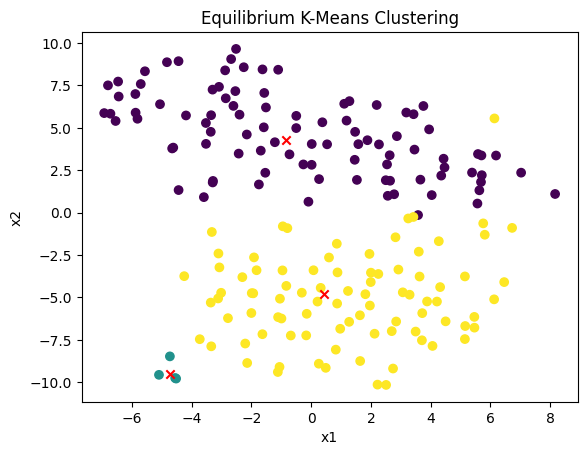

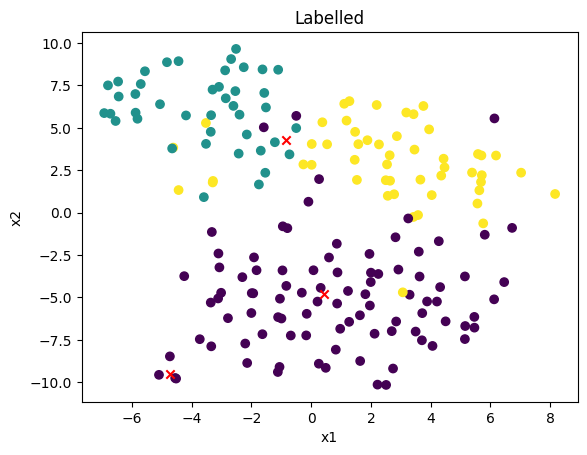

100%|██████████| 63/63 [00:01<00:00, 54.14it/s]


In [11]:
"""### Demo with validation set
This section demonstrate the functionality of t-SNE and clustering with the finetuning validation set.
 - Use clustered label
 - Use ground truth label
"""
# Generate X, label
X, label = [], []
with torch.no_grad():
    for img, lab in finetune_valid_dataset:
        _, probs, latent_embedding = model(img.unsqueeze(0).to(finetune_config.device))
        X.append(latent_embedding.cpu().numpy())
        label.append(lab)
X, label = np.concatenate(X), np.array(label)

# consider three classes
cls1, cls2, cls3 = 2, 5, 8
cls_idx = np.where((label==cls1) | (label==cls2) | (label==cls3))
X = X[cls_idx]
label = label[cls_idx]

# Perform equilibrium k-means clustering
k = 3
alpha = 0.1
n_iter = 50
centroids = equilibrium_k_means(X, k, alpha, n_iter)
clustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))

# 使用 np.bincount 計算每個群集 (0, 1, 2) 的資料點數量
cluster_sizes = np.bincount(clustering, minlength=k)
print(f"--- K-Means 分群結果 (Alpha={alpha}) ---")
print(f"群集大小: {cluster_sizes}")
print(f"排序後的大小: {sorted(cluster_sizes, reverse=True)}")

# t-SNE
Y = prune_dimension(np.concatenate([X, centroids]))
Y, centroids = Y[:-3], Y[-3:]

# plot
plot_clusters(Y, centroids, clustering)
plot_clusters(Y, centroids, label, 'Labelled')

# train on class 1 (cars)
class1_dataset = ImageDataset(load_unlabelled('./data/dev/labelled/2/'))
class1_loader = DataLoader(class1_dataset, batch_size=8, shuffle=True)
model = Autoencoder()
pretrain(model, class1_loader, None, Namespace(
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = pretrain_config.lr,
    weight_decay = 0,
    noise_factor = 0,
    pretrain_epochs = 50
))

Anomaly loss: 0.05373283475637436
Normal loss : 0.013862560370138713


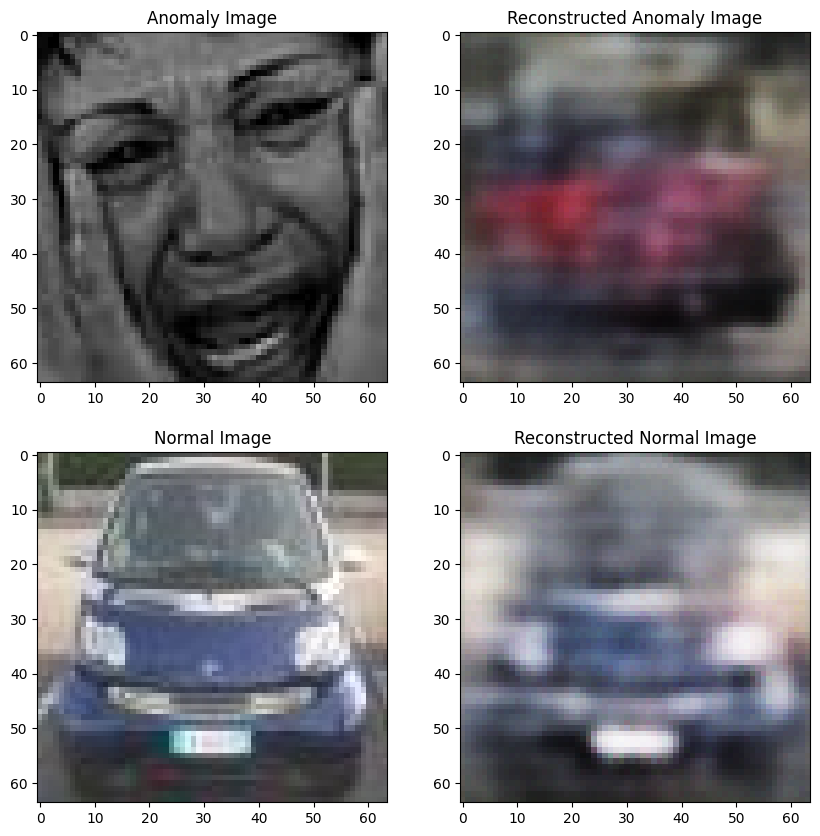

In [12]:
"""### Anomaly detection
This section demonstrate the usage of autoencoders for anomaly detection.

We use the autoencoder to reconstruct an image of an unseen class.
"""
# Use the anomaly dataset and the pre-trained model to generate latent embeddings
anomaly_dataset = ImageDataset(load_unlabelled('data/anomoly'), tfm=T.Compose([
  T.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by adding channels
  T.ToTensor()
]))
anomaly_loader = DataLoader(anomaly_dataset, batch_size=pretrain_config.batch_size, shuffle=False)

# compare losses
anomaly_loss = []
with torch.no_grad():
  for image in anomaly_loader:
      image = image.to(pretrain_config.device)
      recon, _, _ = model(image)
      loss = nn.MSELoss()(recon, image)
      anomaly_loss.append(loss.item())
anomaly_loss = sum(anomaly_loss) / len(anomaly_loss)
print('Anomaly loss:', anomaly_loss)

class1_loss = []
with torch.no_grad():
  for image in class1_loader:
      image = image.to(pretrain_config.device)
      recon, _, _ = model(image)
      loss = nn.MSELoss()(recon, image)
      class1_loss.append(loss.item())
class1_loss = sum(class1_loss) / len(class1_loss)
print('Normal loss :', class1_loss)

# Show
# 1. a pair of reconstructed image and original image for the anomaly class
# 2. a pair of reconstructed image and original image for the normal class
idx1, idx2 = 42, 10
image1, image2 = anomaly_dataset[idx1], class1_dataset[idx2]
model.eval()
with torch.no_grad():
  recon1 = model(image1.unsqueeze(0).to(pretrain_config.device))[0].cpu().numpy()
  recon2 = model(image2.unsqueeze(0).to(pretrain_config.device))[0].cpu().numpy()

# plot the 4 images
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(image1.numpy().transpose((1, 2, 0)))
axs[0, 0].set_title('Anomaly Image')
axs[0, 1].imshow(recon1.squeeze().transpose((1, 2, 0)))
axs[0, 1].set_title('Reconstructed Anomaly Image')
axs[1, 0].imshow(image2.numpy().transpose((1, 2, 0)))
axs[1, 0].set_title('Normal Image')
axs[1, 1].imshow(recon2.squeeze().transpose((1, 2, 0)))
axs[1, 1].set_title('Reconstructed Normal Image')
plt.show()